In [139]:
import numpy as np
import pandas as pd

from scipy.stats import f_oneway
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import model_selection
from sklearn import linear_model

from catboost import CatBoostClassifier
from hyperopt import hp, fmin, tpe, Trials, space_eval

# from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# IO utils


In [3]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [4]:
palm_file = './data/2023-05-31_17-14-41.palm'
gestures = read_omg_csv(
    palm_file, 
    n_omg_channels=50,
    n_acc_channels=3, 
    n_gyr_channels=3, 
    n_enc_channels=6, 
    n_mag_channels=0
)

print(gestures.shape)
gestures.head()

(19568, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,12,8,5,6,2,4,5,7,14,8,...,-13,0,0,0,0,0,0,0,0,555777
1,13,8,4,5,3,0,5,4,9,10,...,-16,0,0,0,0,0,0,0,0,555810
2,12,5,9,5,0,0,6,5,10,9,...,-14,0,0,0,0,0,0,0,0,555843
3,10,7,6,4,1,0,4,6,7,8,...,-12,0,0,0,0,0,0,0,0,555876
4,12,6,6,7,3,2,6,7,9,12,...,-12,0,0,0,0,0,0,0,0,555909


In [5]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [6]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


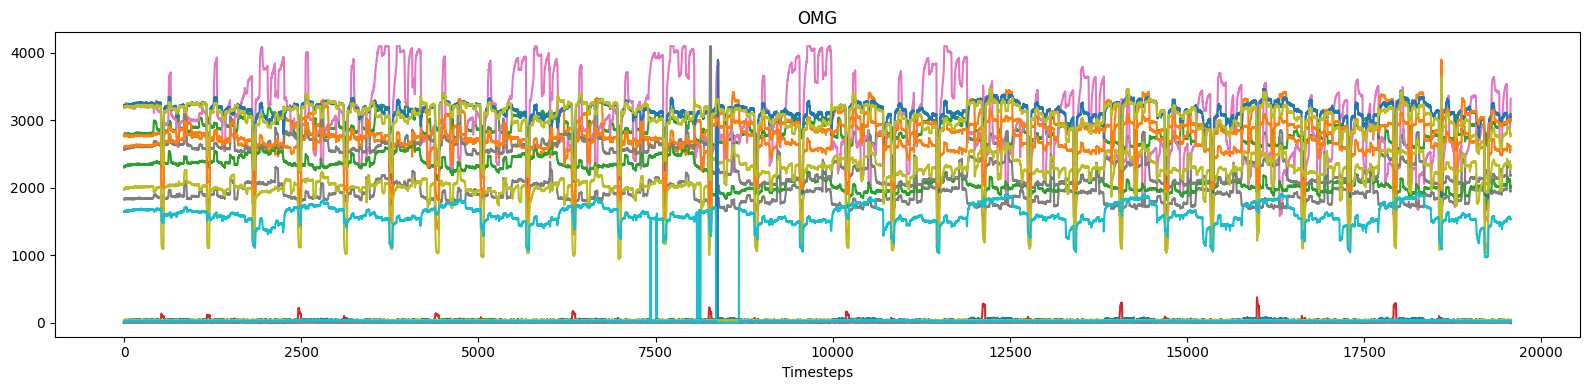

In [7]:
fig = plt.figure(figsize=(16, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

### Protocol

In [8]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
print('Shape of data:', gestures_protocol.shape)
gestures_protocol.head()

Shape of data: (181, 11)


,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [9]:
gestures['SYNC'].value_counts()

0      11266
57        58
67        58
97        47
135       47
       ...  
52        46
1         45
103       45
104       45
12        39
Name: SYNC, Length: 181, dtype: int64

In [10]:
le = preprocessing.LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
    
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [11]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [12]:
gestures_protocol['gesture']

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 181, dtype: int32

In [13]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

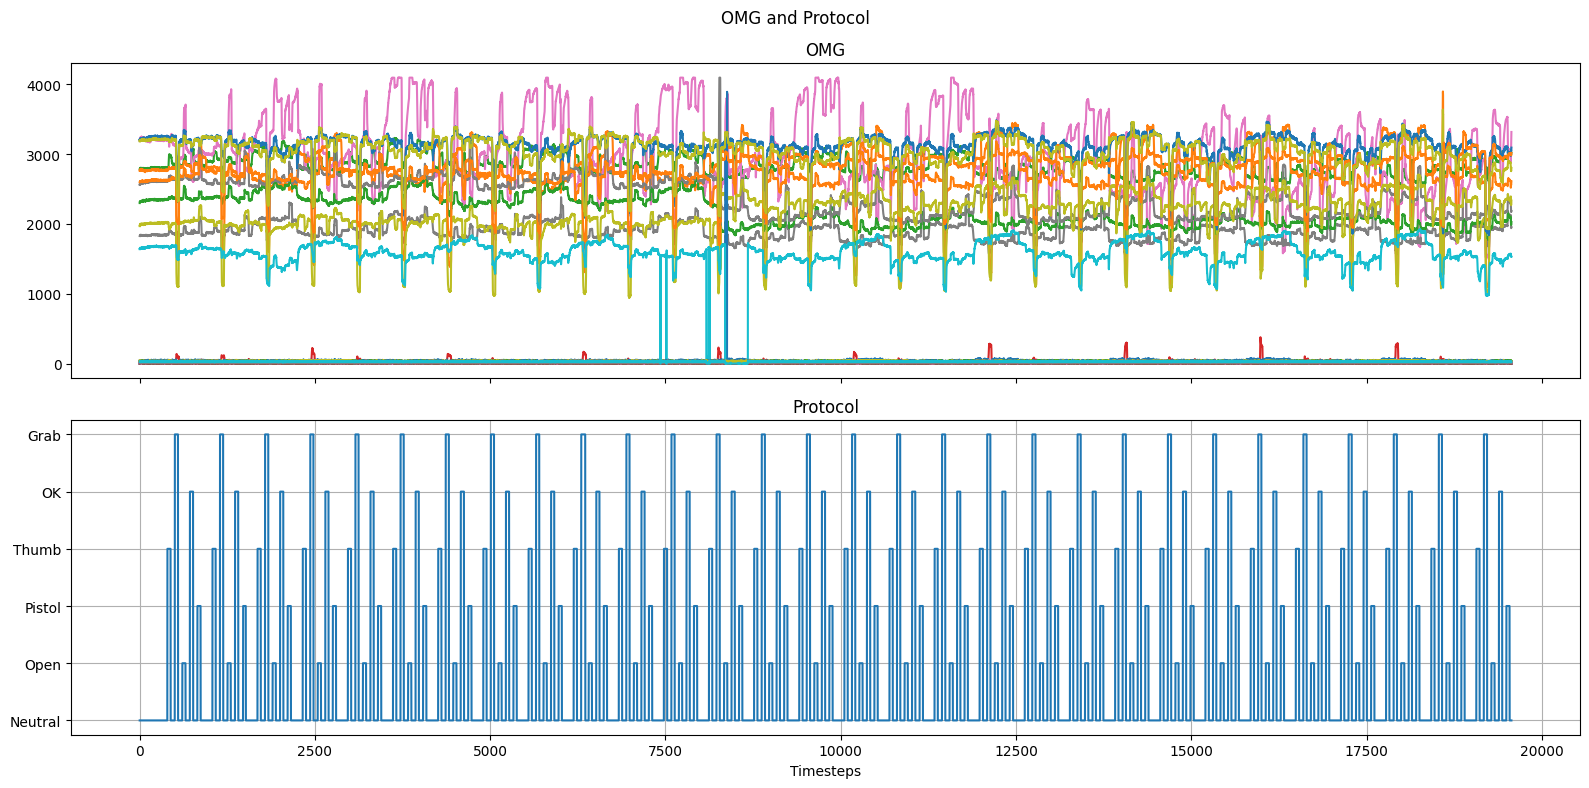

In [14]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

# Train-test split

In [15]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta.head()

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441


In [16]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15679

In [17]:
X_train = gestures[OMG_CH].values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = gestures[OMG_CH].values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15679, 50) (15679,)
(3889, 50) (3889,)


In [18]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,12,8,5,6,2,4,5,7,14,8,...,42,26,14,11,2,2,10,12,44,28
1,13,8,4,5,3,0,5,4,9,10,...,35,23,14,8,3,1,10,14,32,27
2,12,5,9,5,0,0,6,5,10,9,...,38,33,14,9,2,0,19,14,41,27
3,10,7,6,4,1,0,4,6,7,8,...,37,20,14,10,3,0,12,11,32,27
4,12,6,6,7,3,2,6,7,9,12,...,39,21,14,11,3,1,14,12,42,30


In [19]:
pd.Series(y_train).value_counts()

0    10151
5     1118
3     1104
1     1104
4     1104
2     1098
dtype: int64

---
---
---
---
---

# Preprocessing

Пороговый фильтр. Прописать алгоритм как нивелировать задержку между поданной командой и реакцией человека на эту команду.  Ансамбль моделей

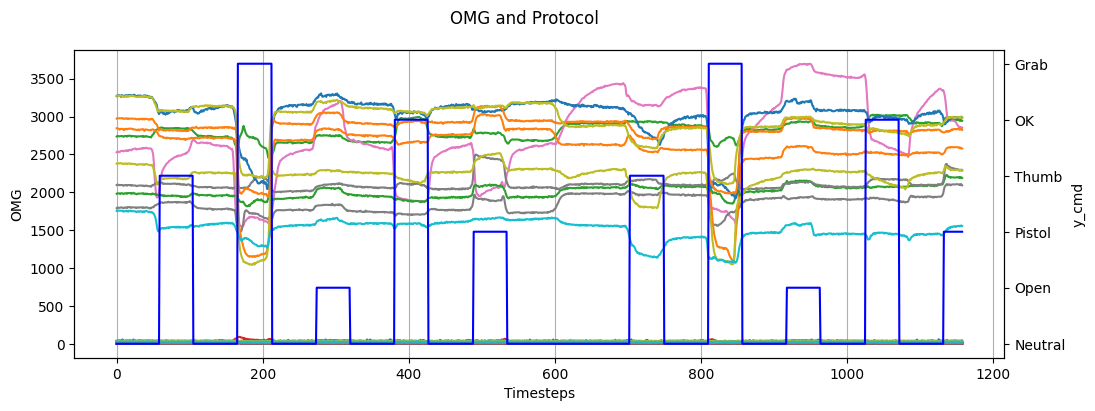

In [183]:
fig, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
plt.suptitle('OMG and Protocol')
ax1.plot(X_train[14500:])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('OMG')
plt.grid(axis='x')
ax2 = ax1.twinx()
ax2.plot(y_train[14500:], 'b-')
ax2.set_ylabel('y_cmd')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.show()

Попробуем метод грубого устранения лага путем смещения значений в строках переменных.

In [21]:
def shifter(train_X, test_X, train_y, test_y, window=20):
    train_X_shifted = pd.DataFrame(train_X).shift(-window)[:-window].values
    test_X_shifted = pd.DataFrame(test_X).shift(-window)[:-window].values
    train_y_shifted = train_y[:-window]
    test_y_shifted = test_y[:-window]
    
    return train_X_shifted, test_X_shifted, train_y_shifted, test_y_shifted

In [22]:
X_train, X_test, y_train, y_test = shifter(X_train, X_test, y_train, y_test)

Проверим результат

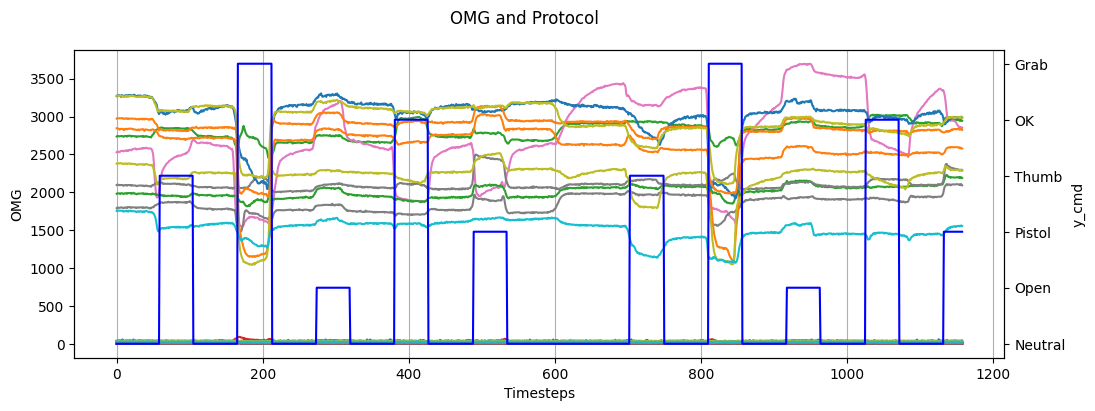

In [176]:
fig, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
plt.suptitle('OMG and Protocol')
ax1.plot(X_train[14500:])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('OMG')
plt.grid(axis='x')
ax2 = ax1.twinx()
ax2.plot(y_train[14500:], 'b-')
ax2.set_ylabel('y_cmd')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.show()

## Экспоненциальное сглаживаение

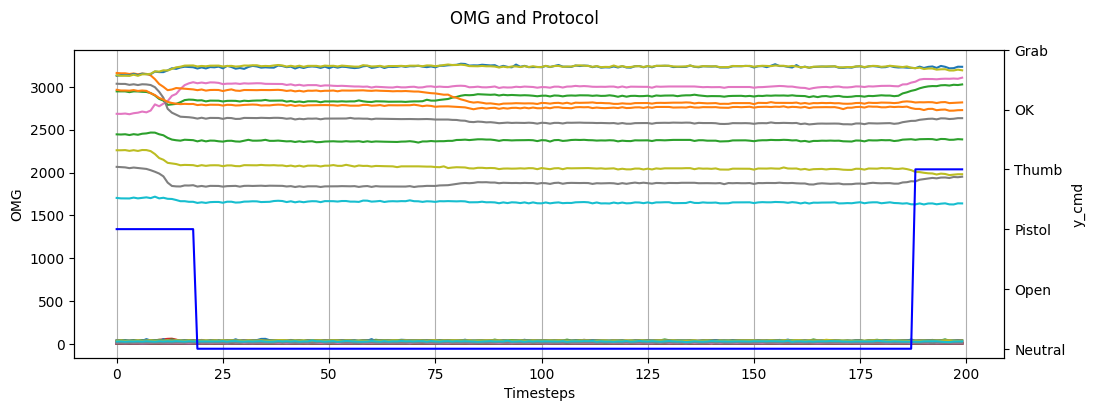

In [174]:
fig, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
plt.suptitle('OMG and Protocol')
ax1.plot(X_train[850:1050])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('OMG')
plt.grid(axis='x')
ax2 = ax1.twinx()
ax2.plot(y_train[850:1050], 'b-')
ax2.set_ylabel('y_cmd')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.show()

## Анализ значимости признаков

In [105]:
%%time
lr = linear_model.LogisticRegression(
    solver='newton-cg',
    random_state=42,
    max_iter=10000,
    n_jobs=-1
)

lr.fit(X_train, y_train)

CPU times: total: 46.9 ms
Wall time: 32min 46s


LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42,
                   solver='newton-cg')

In [167]:
pd.DataFrame(np.absolute(lr.coef_.T)).sort_values(
    by=5, axis=0, ignore_index=False
)[:10]

,0,1,2,3,4,5
28,0.002414,0.008251,0.013194,0.013672,0.006667,0.000352
41,0.012491,0.028808,0.002138,0.007733,0.021199,0.000713
37,0.017434,0.089734,0.117944,0.091855,0.045469,0.000742
39,0.000203,0.001980,0.000314,0.001503,0.000807,0.000846
12,0.010242,0.028118,0.015358,0.027555,0.024381,0.001782
23,0.018070,0.066807,0.000441,0.062788,0.019085,0.002562
6,0.035052,0.060375,0.029280,0.005686,0.057777,0.002684
30,0.000266,0.000666,0.000589,0.000342,0.003641,0.003641
22,0.011433,0.020812,0.001920,0.024745,0.013604,0.004183
27,0.004753,0.004387,0.010301,0.013951,0.007834,0.004956


Анализ коэффициентов не помог выявить незначимые признаки: 

## Корреляционный анализ

In [130]:
def high_correlation_lower_triangle(data, threshold=0.9):
    corr_matrix = pd.DataFrame(data).corr().abs()
    mask = np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool)
    lower_triangle_corr = corr_matrix.where(mask)

    high_corr = (lower_triangle_corr > threshold) & (lower_triangle_corr < 1.0)
    correlated_vars = []

    for column in high_corr.columns:
        correlated = list(high_corr.index[high_corr[column]])
        for var in correlated:
            if high_corr.loc[var, column]:
                correlated_vars.append((column, var))

    return correlated_vars

high_correlation_lower_triangle(X_train)

[(28, 31)]

Удалим один из высокоскореллированных признаков.

In [131]:
# X_train = pd.DataFrame(X_train).drop(28, axis=1)
# X_test = pd.DataFrame(X_test).drop(28, axis=1)
# high_correlation_lower_triangle(X_train)

## Нормализация и стандартизация

In [140]:
mm_scaler = preprocessing.MinMaxScaler()
# rb_scaler = preprocessing.RobustScaler()
st_scaler = preprocessing.StandardScaler()

X_train_mmnorm = mm_scaler.fit_transform(X_train)
X_test_mmnorm = mm_scaler.transform(X_test)
# X_train_rnorm = rb_scaler.fit_transform(X_train)
# X_test_rnorm = rb_scaler.transform(X_test)

X_train_scaled = st_scaler.fit_transform(X_train_mmnorm)
X_test_scaled = st_scaler.transform(X_test_mmnorm)
# X_train_scaled = st_scaler.fit_transform(X_train_rnorm)
# X_test_scaled = st_scaler.transform(X_test_rnorm)

## Устранение мультиколлинеарности

In [141]:
# Матрица корреляций
corr_mtrx = pd.DataFrame(data=X_train_scaled).corr()

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 50
Ранг матрицы:   50
Определитель:   5.62497053859367e-11


In [142]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 99,0 % разброса данных
pca = decomposition.PCA(n_components=0.99, random_state=42).fit(X_train_scaled)
# Обучаем алгоритм на наших данных
print(f'Число компонент: {len(pca.components_)}')

Число компонент: 44


In [143]:
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
# Матрица корреляций
corr_mtrx = np.corrcoef(X_train_pca.transpose())

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 44
Ранг матрицы:   44
Определитель:   0.9999999999999983


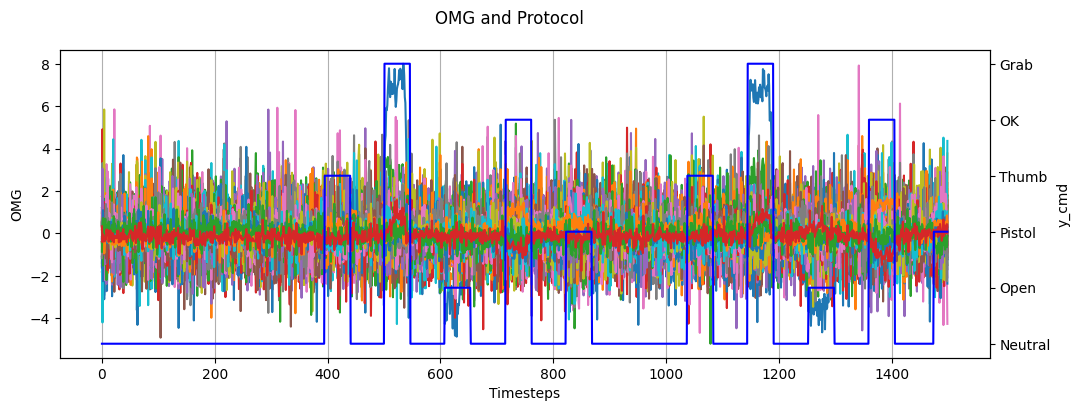

In [144]:
fig, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
plt.suptitle('OMG and Protocol')
ax1.plot(X_train_pca[:1500])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('OMG')
plt.grid(axis='x')
ax2 = ax1.twinx()
ax2.plot(y_train[:1500], 'b-')
ax2.set_ylabel('y_cmd')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.show()

# Modeling

---

### CatBoostClassifier

In [32]:
%%time

space_cbc = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'iterations': hp.randint('iterations', 100, 1000),
    'l2_leaf_reg': hp.randint('l2_leaf_reg', 5, 20),
    'depth': hp.randint('depth', 4, 12),
    'bootstrap_type' : hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli'])
}

# Пишем функцию для оптимизации
def hyperopt_cbc(params, cv=5, X=X_train_pca, y=y_train, random_state=42):
    """ Функция, обучающая модель CatBoostClassifier по переданным гиперпараметрам.
    Args:
        space (dict): Набор гиперпараметров.
        cv (int, optional=5): Количество холдов кросс-валидации. Defaults to 5.
        X (DataFrame): DataFrame-матрица признаков. Defaults to X_train.
        y (Series): Series-вектор целевых значений. Defaults to y_train.
        random_state (int): Рандомное число для воспроизводимости результата. Defaults to random_state.
    Returns:
        score(float): Метрика F1.
    """
    # Укажем модель для оптимизации
    model = CatBoostClassifier(
        **params,
        loss_function='MultiClass',
        random_state=random_state
    )
    # Рассчитаем метрику на кросс-валидации
    score = model_selection.cross_val_score(
        model, X, y, cv=cv, scoring="f1_weighted", n_jobs=-1
    ).mean()
    # Ставим знак минус, т.к. оптимизатор способен лишь минимизировать
    return -score

trials_cbc = Trials() # Логирования результатов  

best_cbc = fmin(
    hyperopt_cbc, # Наша функция 
    space=space_cbc, # Пространство гиперпараметров
    algo=tpe.suggest, # Алгоритм оптимизации, установлен по умолчанию
    max_evals=10, # Максимальное количество итераций
    trials=trials_cbc, # Логирование результатов
    rstate=np.random.default_rng(42) # Параметр воспроизводимости
)
# Печатаем результат
print(f'Лучшие гиперпараметры: {space_eval(space_cbc, best_cbc)}')

Лучшие гиперпараметры: {'bootstrap_type': 'Bayesian', 'depth': 10, 'iterations': 532, 'l2_leaf_reg': 12, 'learning_rate': 0.16319116397500175}


In [36]:
model = CatBoostClassifier(
    **space_eval(space_cbc, best_cbc),
    loss_function='MultiClass',
    verbose=False
)

model.fit(X_train_pca, y_train)

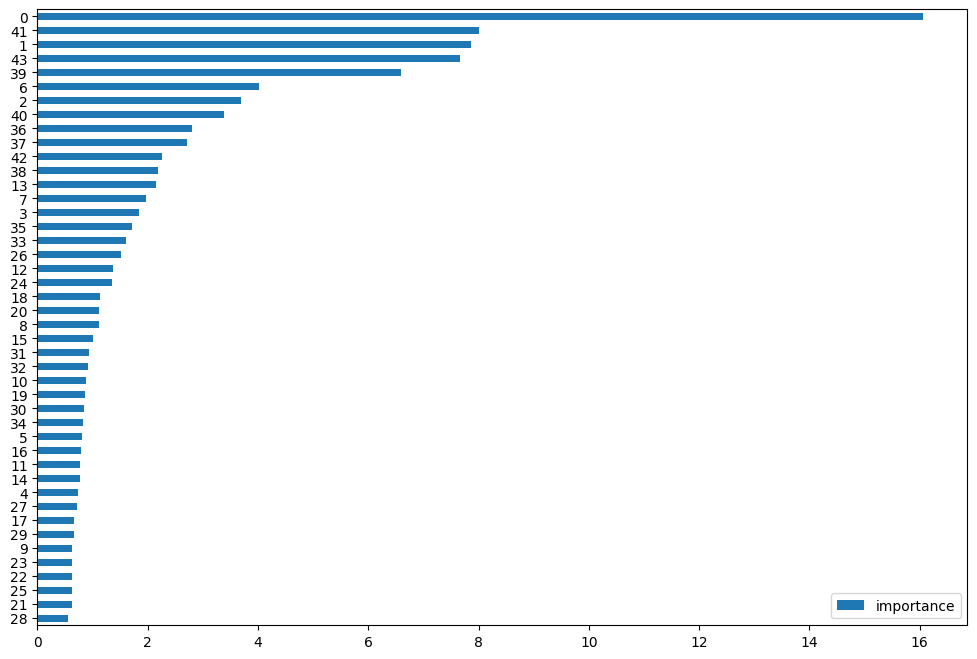

In [37]:
imp = pd.DataFrame(model.feature_importances_, index=range(X_test_pca.shape[1]), columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8));

#### Metrics

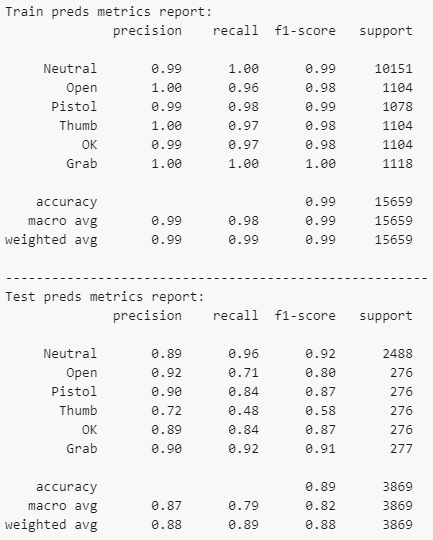

---

### LogisticRegression

In [151]:
%%time
model = linear_model.LogisticRegression(
    solver='newton-cg',
    random_state=42,
    max_iter=10000,
    n_jobs=-1
)

model.fit(X_train_pca, y_train)

CPU times: total: 0 ns
Wall time: 997 ms


LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42,
                   solver='newton-cg')

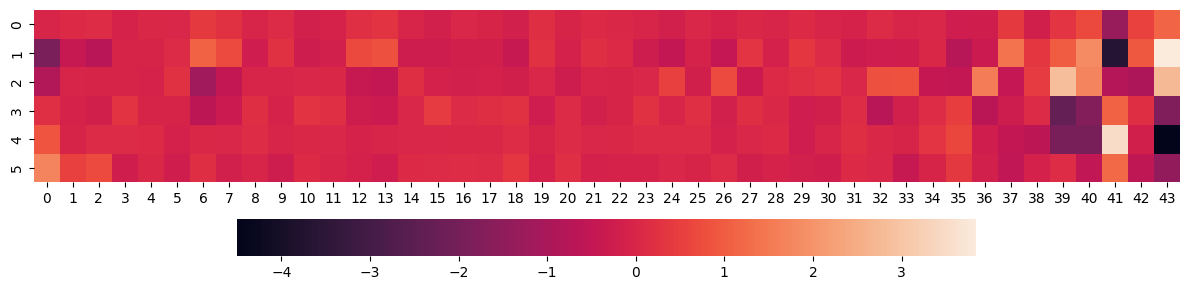

In [152]:
plt.figure(figsize=(12, 3)) # 
sns.heatmap(model.coef_, cbar_kws={"orientation": "horizontal"})
plt.tight_layout()

## Prediction

In [153]:
y_pred_train = model.predict(X_train_pca)
y_pred_test = model.predict(X_test_pca)

# y_pred_train = model.predict(X_train_pca)
# y_pred_test = model.predict(X_test_pca)

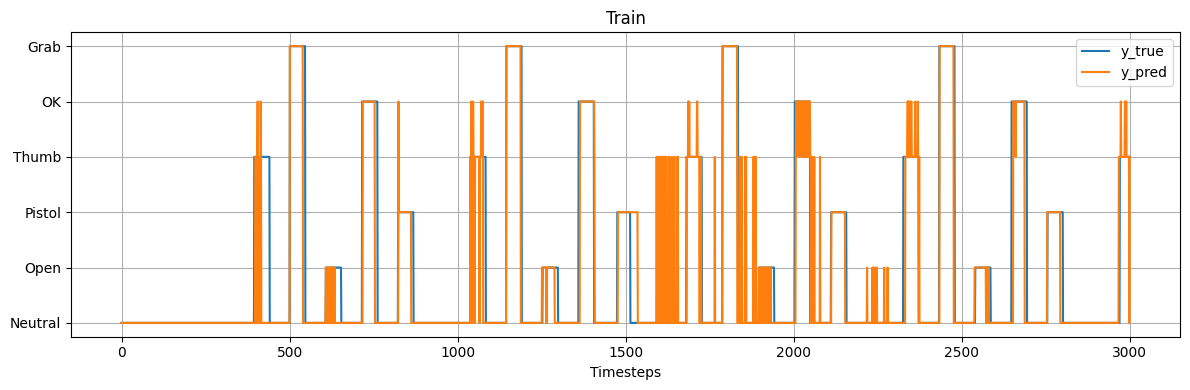

In [154]:
fig = plt.figure(figsize=(12, 4))
plt.plot(y_train[:3000],  c='C0', label='y_true')
plt.plot(y_pred_train[:3000], c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

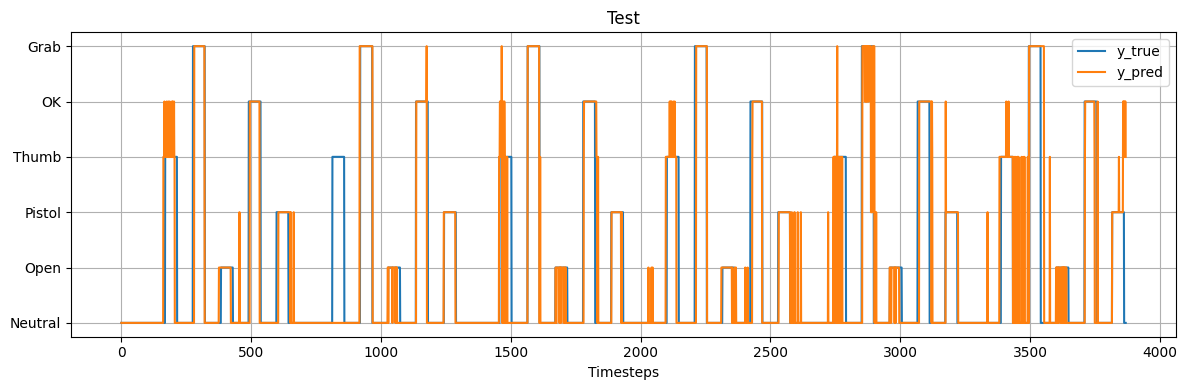

In [155]:
fig = plt.figure(figsize=(12, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [156]:
from sklearn.metrics import classification_report

print('Train preds metrics report:')
print(classification_report(y_train, y_pred_train, target_names=GESTURES))
print('-'*55)
print('Test preds metrics report:')
print(classification_report(y_test, y_pred_test, target_names=GESTURES))

Train preds metrics report:
              precision    recall  f1-score   support

     Neutral       0.90      0.96      0.93     10151
        Open       0.87      0.71      0.78      1104
      Pistol       0.94      0.86      0.90      1078
       Thumb       0.70      0.50      0.59      1104
          OK       0.83      0.76      0.79      1104
        Grab       0.96      0.94      0.95      1118

    accuracy                           0.89     15659
   macro avg       0.87      0.79      0.82     15659
weighted avg       0.88      0.89      0.88     15659

-------------------------------------------------------
Test preds metrics report:
              precision    recall  f1-score   support

     Neutral       0.89      0.95      0.92      2488
        Open       0.89      0.70      0.78       276
      Pistol       0.89      0.91      0.90       276
       Thumb       0.74      0.48      0.58       276
          OK       0.83      0.85      0.84       276
        Grab       0.

In [179]:
def cv_metrics(model, kfold=model_selection.KFold()):
    
    cv_metrics = model_selection.cross_validate(
        estimator=model, #модель
        X=X_train_pca, #матрица наблюдений X
        y=y_train, #вектор ответов y
        scoring='f1_weighted', #метрика
        cv = kfold,
        return_train_score=True #подсчёт метрики на тренировочных фолдах
    )
    
    print('Train k-fold mean f1_weighted: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
    print('Valid k-fold mean f1_weighted: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

In [181]:
%%time
cv_metrics(model)

Train k-fold mean f1_weighted: 0.89
Valid k-fold mean f1_weighted: 0.86
CPU times: total: 46.9 ms
Wall time: 4.64 s


---
---
---
---
---

# Real-time inference

In [177]:
import time
from serial import Serial
from IPython.display import clear_output

In [178]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [123]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [124]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


In [125]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

In [126]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3889, 50)
enc_sample.shape = (3889, 6)
sample_preprocessed.shape = (3889, 50)
y_predicted.shape = (3889, 1)
y_postprocessed.shape = (3889, 1)
y_commands.shape = (3889, 1)


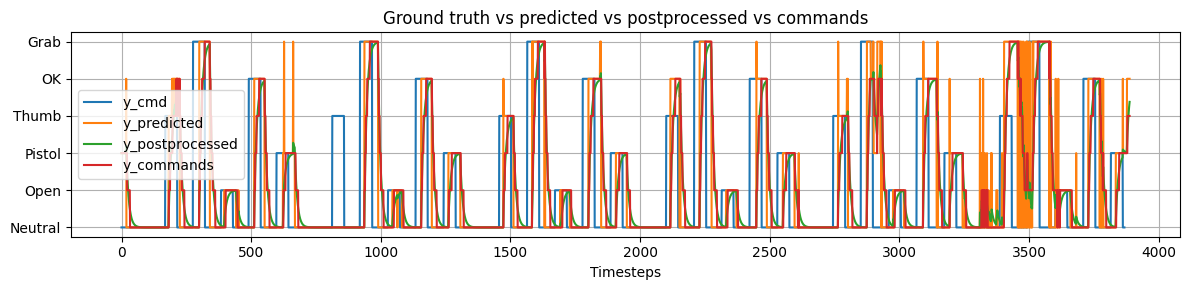

In [127]:
fig = plt.figure(figsize=(12, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [129]:
print(classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.70      0.59      0.64      2488
        Open       0.24      0.57      0.33       276
      Pistol       0.20      0.29      0.24       276
       Thumb       0.23      0.20      0.22       276
          OK       0.09      0.10      0.10       276
        Grab       0.14      0.09      0.11       277

    accuracy                           0.47      3869
   macro avg       0.27      0.31      0.27      3869
weighted avg       0.51      0.47      0.48      3869



### Online (prosthesis or virtual hand)

In [32]:
TIMEOUT = 0.033
DEBUG = True

ser = None
ser_port = None
# ser_port = '/dev/ttyACM0'
# ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

AttributeError: 'NoneType' object has no attribute 'readline'